## Ingest GPM-IMERG data and produce plot of 12-h accumulated precipitation

In [6]:
import xarray as xr
import pandas as pd
import iris

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib.patches import Rectangle
import cmocean

### Plot characteristics

- Latitude + longitude grid subset
- Validity time

In [2]:
lon_start = 93.0 # 88.0
lon_end = 123.0 # 130.0
lat_start = -3.0 # -6.0
lat_end = 20.0 # 23.0

bounds = [lon_start, lon_end, lat_start, lat_end]

Tp = 48
time = int(Tp-12)

### Read in global (N768) MetUM data

- Modify the file path and uncomment the cell below to ingest data for precipitation and wind speed on model levels

In [3]:
# # read in new N768 MetUM data (12-h accumulated precip)
# prcp_data_path = '/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pa{0:03d}.nc'.format(time)
# wind_data_path = '/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pe{0:03d}.nc'.format(time)

### Read in 4p4 MetUM data (October 2023)

- We have two versions of the MetUM data, one in `pp` format and the other `netCDF`
- Read in the `netCDF` file to access the latitude and longitude grids for interpolation 

In [13]:
data_nc_4p4 = '/nobackup/earshar/borneo/20181021T1200Z_SEA4_km4p4_ra1tld_pverb.nc'
data_pb = xr.open_dataset(data_nc_4p4).metpy.parse_cf()
prcp_grid = data_pb['p'].sel(longitude=slice(bounds[0], bounds[1]), latitude=slice(bounds[2], bounds[3])).isel(t=0).squeeze('msl')

- Read in the `pp` file to ingest and process the precipitation data
- Uncomment the lines below to run this part of the code

In [7]:
# # process 4p4 MetUM data and extract 12-h accumulated precipitation 
# data_path_4p4 = '{0}_pverb.pp'.format(data_path_4p4)
# pcubes = iris.load(data_path_4p4)
# prcp_4p4_data = xr.DataArray.from_iris(pcubes.extract('stratiform_rainfall_flux')[1])

# # subset and extract 12-h accumulated precipitation 
# prcp_4p4_data = prcp_4p4_data.sel(longitude=slice(bounds[0], bounds[1]), latitude=slice(bounds[2], bounds[3]))
# prcp_4p4_data = prcp_4p4_data * 3600. 
# prcp_4p4_data = prcp_4p4_data.resample(time="12H").sum().sel(time = slice('2018-10-21T12', '2018-10-26T12') )

### Vortex track + intensity data

- Convert time integers to datetime objects
- Extract track information between 12Z on 21 and 26 October

In [14]:
vortex_path = '/home/home02/earshar/borneo_vortex/borneo_vortex_2018102112_track.txt'
vortex_df = pd.read_csv(vortex_path, sep=' & ', engine='python', na_filter=True, na_values="1.000000e+25")
vortex_df['Time'] = pd.to_datetime(vortex_df['Time'], format='%Y%m%d%H')
bv_lat = vortex_df.loc[0:20, "lat_vort"];
bv_lon = vortex_df.loc[0:20, "lon_vort"]
bv_time = vortex_df.loc[0:20, "Time"]

### Read in Himawari-8 satellite data

- Modify the file path and uncomment the cell below to ingest this brightness temperature satellite data

In [8]:
# single_date_str = date_str.strftime("%Y%m%d_%H00")
# himawari_path = '/nobackup/earshar/borneo/himawari/himawari_10.4_{0}.nc'.format(single_date_str)

### Read in GPM-IMERG satellite data 

- Divide by 2 (each 30-min interval contains precipitation rate in mm/hr)
- Resample to calculate 12-h accumulated precipitation

In [18]:
gpm_path = '/nobackup/earshar/borneo/GPMHH_201810.nc'
gpm_data = xr.open_dataset(gpm_path).sel(lon=slice(bounds[0], bounds[1]), lat=slice(bounds[2], bounds[3]))
prcp_gpm = gpm_data.precipitationCal
prcp_gpm = prcp_gpm / 2
prcp_gpm_12h = prcp_gpm.resample(time="12H").sum().sel(time=slice('2018-10-21T12', '2018-10-26T12'))

### Open N768 MetUM data using xarray 

- Process by removing unnecessary dimensions

In [12]:
# prcp_data = xr.open_dataset(prcp_data_path)
# wind_data = xr.open_dataset(wind_data_path)

# # process precipitation data 
# prcp_sub = prcp_data.squeeze('surface').sel(longitude=slice(lon_start, lon_end),
#                                             latitude=slice(lat_start, lat_end))
# prcp_n768 = prcp_sub['tot_precip'].squeeze('t_1')

### Plot 4.4 km MetUM precipitation data

- Overlay box around Borneo vortex centre position

In [37]:
# # 4p4 MetUM plot (Figs. 3a + 4a)

# fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# # domain extent
# ax.set_extent([lon_start, lon_end, lat_start, lat_end], ccrs.PlateCarree())
# # gridlines
# ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.75, color='k', linestyle=':')
# # customise further 
# Levels=[1.0, 2.0, 4.0, 8.0, 16.0, 24.0, 32.0, 48.0, 64.0, 96.0, 128.0]

# # plot data 
# prcp_4p4 = prcp_4p4_data.sel(time='2018-10-24T00')
# prcp_4p4.plot.contourf(ax=ax, levels=Levels, extend='max', 
#                         transform=ccrs.PlateCarree(),
#                         cbar_kwargs={'label': 'mm'},
#                         cmap=cmocean.cm.haline_r)

# # customise plot
# ax.coastlines(resolution='10m', color='k', linewidth=1)
# ax.set_xticks([94, 99, 104, 109, 114, 119])
# ax.set_yticks([-2, 1, 4, 7, 10, 13, 16, 19])
# ax.set_xticklabels([94, 99, 104, 109, 114, 119], fontsize='large')
# ax.set_yticklabels([-2, 1, 4, 7, 10, 13, 16, 19], fontsize='large')
# ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')
# ax.set_ylabel(r'latitude ($\degree$N)', fontsize='large')
# ax.set_title('')

# # overlay BV box position 
# r0 = 3.0
# ax.add_patch( Rectangle( (bv_lon[12]-r0, bv_lat[12]-r0),
#                             2*r0, 2*r0, linewidth=2,
#                             facecolor='none', edgecolor='k') )

# fig.savefig('fig4a.png', dpi=200)

### Preprocess GPM-IMERG data

- (1) calculate 12-h accumulated precip
- (2) interpolate onto 4p4 MetUM grid
- (3) transpose

In [19]:
prcp_gpm_oct23 = prcp_gpm_12h.sel(time='2018-10-23T00').squeeze('time')
prcp_gpm_oct24 = prcp_gpm_12h.sel(time='2018-10-24T00').squeeze('time')

prcp_plot_oct23 = prcp_gpm_oct23.interp(lon=prcp_grid["longitude"],
                                lat=prcp_grid["latitude"],
                                method="linear")

prcp_plot_oct24 = prcp_gpm_oct24.interp(lon=prcp_grid["longitude"],
                                lat=prcp_grid["latitude"],
                                method="linear")

prcp_plot_oct23 = prcp_plot_oct23.transpose('latitude', 'longitude')
prcp_plot_oct24 = prcp_plot_oct24.transpose('latitude', 'longitude')

### Plot GPM-IMERG data

- GPM plot (Figs. 4b and A1b from the paper)

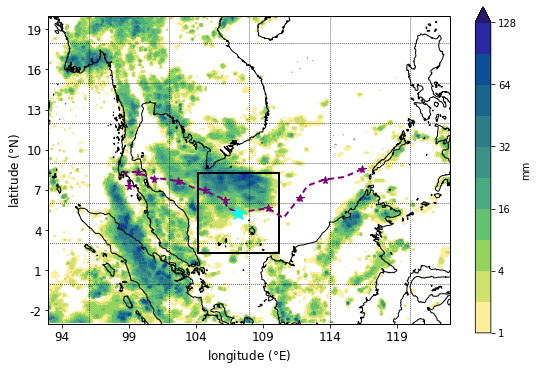

In [17]:
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# domain extent
ax.set_extent([lon_start, lon_end, lat_start, lat_end], ccrs.PlateCarree())
# gridlines
ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.75, color='k', linestyle=':')
# customise further 
Levels=[1.0, 2.0, 4.0, 8.0, 16.0, 24.0, 32.0, 48.0, 64.0, 96.0, 128.0]

# plot data 
prcp_plot_oct23.plot.contourf(ax=ax, levels=Levels, extend='max', 
                        transform=ccrs.PlateCarree(),
                        cbar_kwargs={'label': 'mm'},
                        cmap=cmocean.cm.haline_r)

# customise plot
ax.coastlines(resolution='10m', color='k', linewidth=1)
ax.set_xticks([94, 99, 104, 109, 114, 119])
ax.set_yticks([-2, 1, 4, 7, 10, 13, 16, 19])
ax.set_xticklabels([94, 99, 104, 109, 114, 119], fontsize='large')
ax.set_yticklabels([-2, 1, 4, 7, 10, 13, 16, 19], fontsize='large')
ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')
ax.set_ylabel(r'latitude ($\degree$N)', fontsize='large')
ax.set_title('')

# overlay BV box position 
r0 = 3.0
ax.add_patch( Rectangle( (bv_lon[8]-r0, bv_lat[8]-r0),
                            2*r0, 2*r0, linewidth=2,
                            facecolor='none', edgecolor='k') )

# overlay entire Borneo vortex track
ax.plot(bv_lon[:], bv_lat[:], '*', ms=8, markevery=2, linewidth=2, dashes=[3,2], color='purple')

# overlay Borneo vortex centre position
ax.plot(bv_lon[8], bv_lat[8], marker='*', markersize=16, color='cyan')

fig.savefig('fig4b.png',dpi=200)

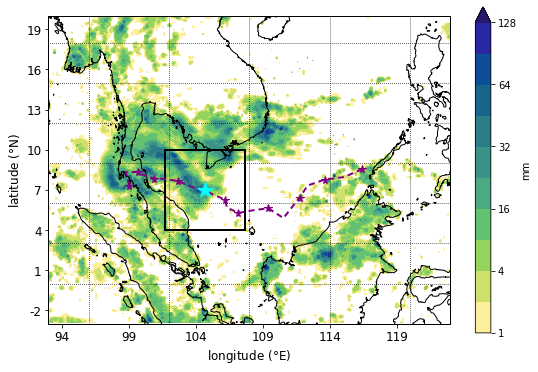

In [20]:
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# domain extent
ax.set_extent([lon_start, lon_end, lat_start, lat_end], ccrs.PlateCarree())
# gridlines
ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.75, color='k', linestyle=':')
# customise further 
Levels=[1.0, 2.0, 4.0, 8.0, 16.0, 24.0, 32.0, 48.0, 64.0, 96.0, 128.0]

# plot data 
prcp_plot_oct24.plot.contourf(ax=ax, levels=Levels, extend='max', 
                        transform=ccrs.PlateCarree(),
                        cbar_kwargs={'label': 'mm'},
                        cmap=cmocean.cm.haline_r)

# customise plot
ax.coastlines(resolution='10m', color='k', linewidth=1)
ax.set_xticks([94, 99, 104, 109, 114, 119])
ax.set_yticks([-2, 1, 4, 7, 10, 13, 16, 19])
ax.set_xticklabels([94, 99, 104, 109, 114, 119], fontsize='large')
ax.set_yticklabels([-2, 1, 4, 7, 10, 13, 16, 19], fontsize='large')
ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')
ax.set_ylabel(r'latitude ($\degree$N)', fontsize='large')
ax.set_title('')

# overlay BV box position 
r0 = 3.0
ax.add_patch( Rectangle( (bv_lon[12]-r0, bv_lat[12]-r0),
                            2*r0, 2*r0, linewidth=2,
                            facecolor='none', edgecolor='k') )

# overlay entire Borneo vortex track
ax.plot(bv_lon[:], bv_lat[:], '*', ms=8, markevery=2, linewidth=2, dashes=[3,2], color='purple')

# overlay Borneo vortex centre position
ax.plot(bv_lon[12], bv_lat[12], marker='*', markersize=16, color='cyan')

fig.savefig('fig5b_new.png', dpi=200)

### Plot 12-h accumulated rainfall from N768 MetUM data

- Overlay box around Borneo vortex centre position

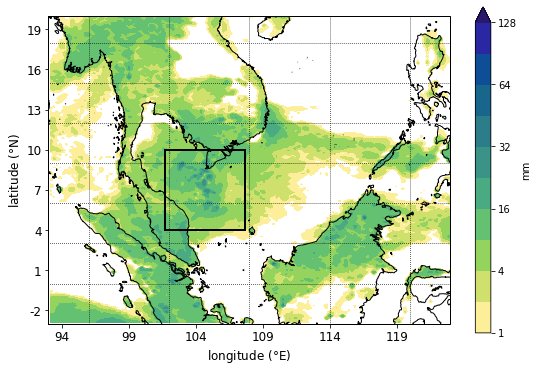

In [39]:
# # N768 MetUM plot (Figs. 3c + 4c)

# fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# # domain extent
# ax.set_extent([lon_start, lon_end, lat_start, lat_end], ccrs.PlateCarree())
# # gridlines
# ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.75, color='k', linestyle=':')
# # customise further 
# Levels=[1.0, 2.0, 4.0, 8.0, 16.0, 24.0, 32.0, 48.0, 64.0, 96.0, 128.0]

# # plot data 
# prcp_n768.plot.contourf(ax=ax, levels=Levels, extend='max', 
#                         transform=ccrs.PlateCarree(),
#                         cbar_kwargs={'label': 'mm'},
#                         cmap=cmocean.cm.haline_r)

# # customise plot
# ax.coastlines(resolution='10m', color='k', linewidth=1)
# ax.set_xticks([94, 99, 104, 109, 114, 119])
# ax.set_yticks([-2, 1, 4, 7, 10, 13, 16, 19])
# ax.set_xticklabels([94, 99, 104, 109, 114, 119], fontsize='large')
# ax.set_yticklabels([-2, 1, 4, 7, 10, 13, 16, 19], fontsize='large')
# ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')
# ax.set_ylabel(r'latitude ($\degree$N)', fontsize='large')
# ax.set_title('')

# # overlay BV box position 
# r0 = 3.0
# ax.add_patch( Rectangle( (bv_lon[12]-r0, bv_lat[12]-r0),
#                             2*r0, 2*r0, linewidth=2,
#                             facecolor='none', edgecolor='k') )

# fig.savefig('fig4c_new.png', dpi=200)

### Process and plot brightness temperature data from Himawari-8 satellite

- Overlay box around Borneo vortex centre position

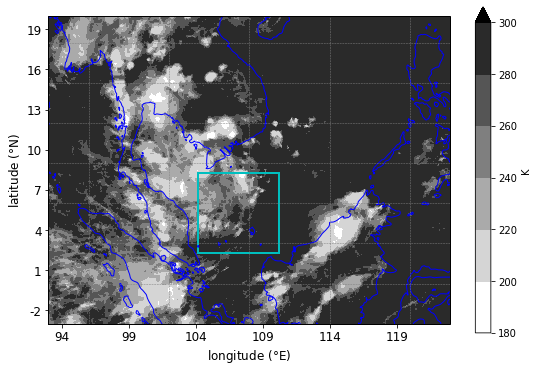

In [52]:
# himawari_data = xr.open_dataset(himawari_path).metpy.parse_cf()

# fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# # domain extent
# ax.set_extent([lon_start, lon_end, lat_start, lat_end], ccrs.PlateCarree())
# # gridlines
# plt.gca().gridlines(color='grey', linestyle='--', linewidth=0.5)
# ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='blue', linewidth=1.0)

# # plot data 
# Levels=[180, 200, 220, 240, 260, 280, 300]
# t_bright = himawari_data.T_b
# t_bright.plot.contourf(ax=ax, levels=Levels, extend='max', transform=ccrs.PlateCarree(),
#                         cbar_kwargs={'label': 'K'},
#                         cmap='gist_yarg')

# # customise plot      
# ax.set_xticks([94, 99, 104, 109, 114, 119])
# ax.set_yticks([-2, 1, 4, 7, 10, 13, 16, 19])
# ax.set_xticklabels([94, 99, 104, 109, 114, 119], fontsize='large')
# ax.set_yticklabels([-2, 1, 4, 7, 10, 13, 16, 19], fontsize='large')
# ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')
# ax.set_ylabel(r'latitude ($\degree$N)', fontsize='large')
# ax.set_title('')

# # overlay BV box position 
# r0 = 3.0
# ax.add_patch( Rectangle( (bv_lon[8]-r0, bv_lat[8]-r0),
#                             2*r0, 2*r0, linewidth=2,
#                             facecolor='none', edgecolor='c') )

# fig.savefig('fig4d.png', dpi=200)